# XAI CODE DEMO

## Explainable AI Specialization on Coursera

# Testing Concept Activation Vectors (TCAV) ↗

For any given concept, TCAV measures the extent of that concept’s influence on the model’s prediction for a certain class

Concept Activation Vectors (CAV) are a numerical representation of a concept in the activation space of a neural network layer

**Implementation:**

1. Curate two datasets
* A concept dataset that represents concept C
* A random dataset

2. Target a hidden layer 𝑙 and train a binary classifier which separates the activations generated by the concept set from those generated by the random set
* The binary classifier can be an SVM or logistic regression model
* The coefficient vector of this trained binary classifier is the CAV, vlc

3. Given an image input 𝑥, we can measure its conceptual sensitivity by calculating the directional derivative of the prediction in the direction of the unit CAV

**In Practice**

Instead of training only one CAV, we train multiple CAVs using different random datasets while keeping the concept dataset the same. A meaningful concept will generate CAVs with consistent TCAV scores.

Steps:
1. Collect N  random datasets (Recommendation: N >= 10)
2. Fix the concept dataset and calculate TCAV score using each of N random datasets
3. Apply a two-sided t-test to N TCAV scores against other N TCAV scores generated by a random CAV
* A random CAV can be obtained by choosing a random dataset as the concept dataset
* Use multiple hypothesis correction for your hypothesis testing

---


This tutorial was adapted from the [original paper's demo, ](https://github.com/tensorflow/tcav/blob/master/Run_TCAV_on_colab.ipynb)available on GitHub.

To implement TCAV, you will need
* Example images for each concept, images for the class/labels of interest, and random images that don't belong to any concepts
* Model wrapper (we use the example from tcav/model.py) - this tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
* act_generator (we use the example from tcav/activation_generator.py)- an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model

In [ ]:
# We are going to clone the tcav repo in GitHub:
!git clone https://github.com/tensorflow/tcav.git tcav
%cd tcav
!ls

# Next, we will create the datasets
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=YOUR_FOLDER --number_of_images_per_folder=10 --number_of_random_folders=10

%cd /content/tcav

Cloning into 'tcav'...
remote: Enumerating objects: 709, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 709 (delta 4), reused 3 (delta 0), pack-reused 697
Receiving objects: 100% (709/709), 639.09 KiB | 4.18 MiB/s, done.
Resolving deltas: 100% (405/405), done.
/content/tcav
CONTRIBUTING.md        LICENSE	  requirements.txt  Run_TCAV_on_colab.ipynb  tcav
FetchDataAndModels.sh  README.md  Run_TCAV.ipynb    setup.py
/content/tcav/tcav/tcav_examples/image_models/imagenet
Created source directory at YOUR_FOLDER
Downloaded 10 for zebra
Successfully created data at YOUR_FOLDER
/content/tcav


In [ ]:
!pip install tcav matplotlib==2.2.4 Pillow==8.2.0 scikit-learn==0.20.3 scipy==1.2.1 tensorflow==2.14.1 numpy==1.19.2

In [ ]:
# Basic
import os
import absl
import random
import matplotlib.pyplot as plt
from PIL import Image

# Models
import tensorflow as tf

#XAI
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot


### Curate + store data

* **source_dir**: directories for images of concepts, target class and random images. Each should be a sub-folder within this directory.
    * You need roughly 50-200 images per concept and target class (10-20 will work, but 200 is recommended by original paper authors).

* **cav_dir**: directory to store CAVs (`None` if you don't want to store)

* **target, concept**: names of the target class and concepts (strings) - these are folder names in source_dir

* **bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV

In [ ]:
# Model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# Name of the parent directory that results are stored (if cacheing)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# Location where activations are stored
activation_dir =  working_dir+ '/activations/'
# Location where CAVs are stored (or None if not storing)
cav_dir = working_dir + '/cavs/'
# Location of images
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
# Bottleneck layer
bottlenecks = ['mixed4c']

# Create directories if they don't exist
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# Regularizer penalty parameter for linear classifier to get CAVs
alphas = [0.1]

target = 'zebra'
concepts = ["dotted","striped","zigzagged"]

In [ ]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' '/content/tcav/tcav/mobilenet_v2_1.0_224'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' -> '/content/tcav/tcav/mobilenet_v2_1.0_224'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite'
'/content/tcav/tcav/tcav_examples/image_models/imag

In [ ]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' -> '/content/tcav/tcav/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/LICENSE'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h': Is a directory


### Visualize Images from the Target, Concepts, and Random folders

Images from target folder:


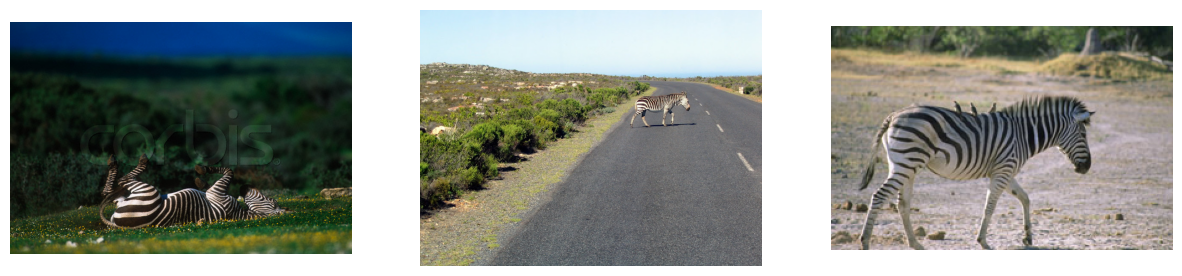

Images from dotted folder:


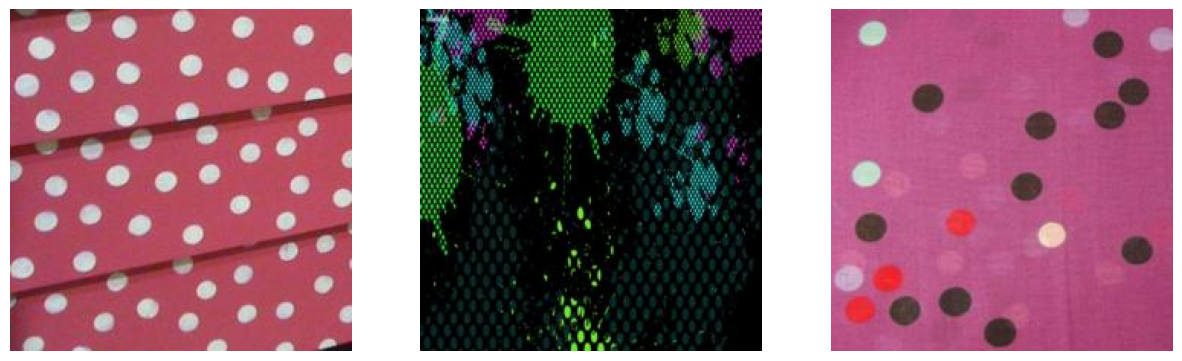

Images from striped folder:


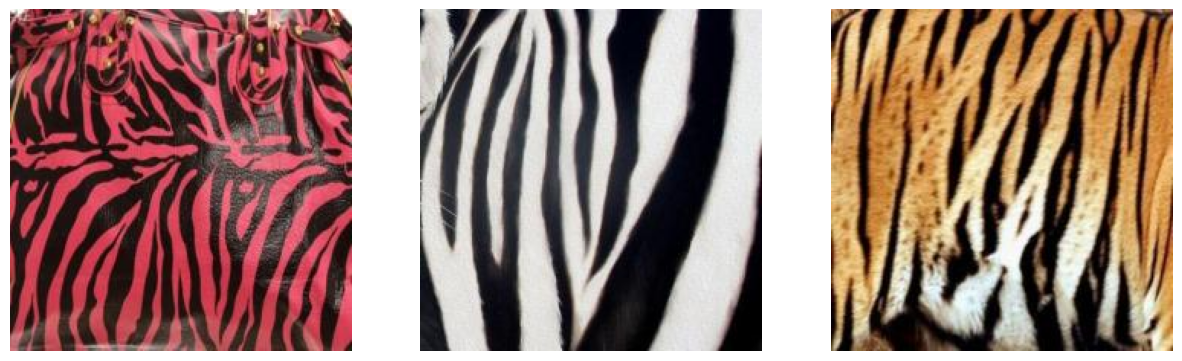

Images from zigzagged folder:


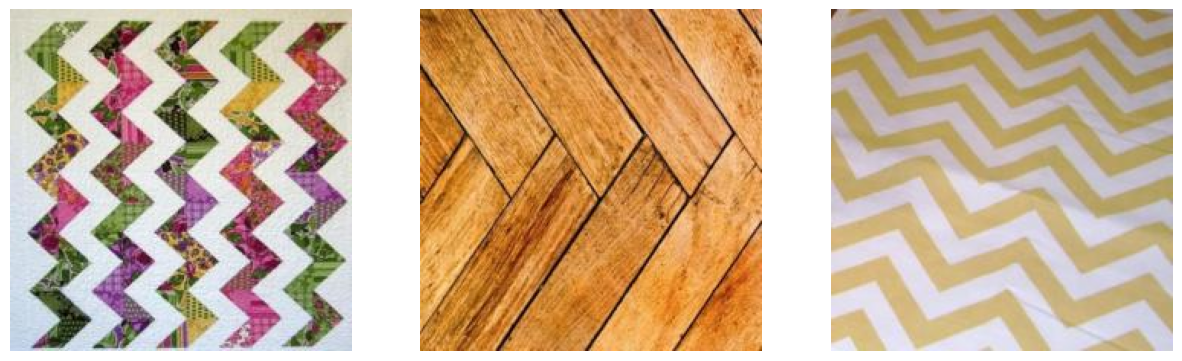

Images from random folder:


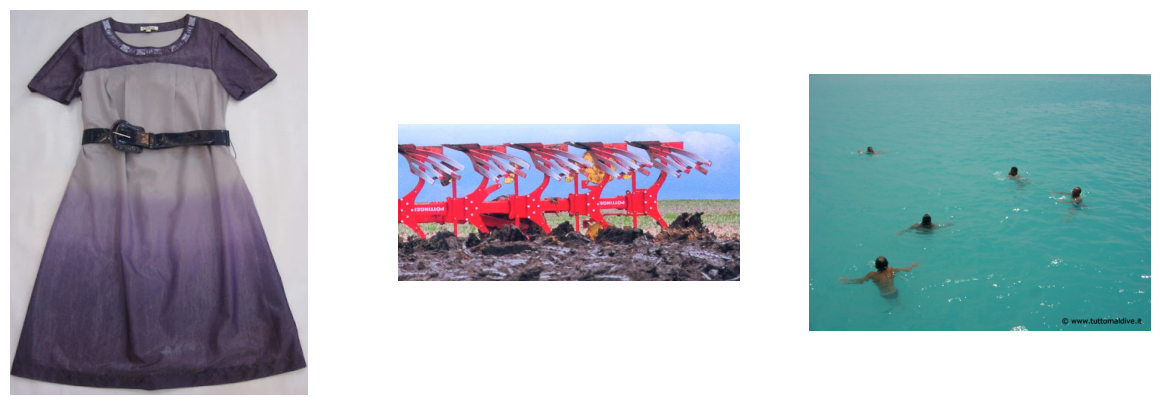

In [ ]:
def display_random_images(directory, num_images):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Filter out non-image files
    image_files = [f for f in files if f.endswith('.jpg')]

    # Check if there are enough image files
    if len(image_files) < num_images:
        print(f"Not enough images in {directory}.")
        return

    # Select random images
    random_images = random.sample(image_files, num_images)

    # Display selected images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

# Define source directory
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
target = 'zebra'
concepts = ["dotted","striped","zigzagged"]
random_folder = 'random500_10'

# Display 3 images from the target folder in a row
print("Images from target folder:")
display_random_images(os.path.join(source_dir, target), 3)

# Display 3 images from each concept folder
for concept in concepts:
    print(f"Images from {concept} folder:")
    display_random_images(os.path.join(source_dir, concept), 3)

# Display 3 images from a random folder
print("Images from random folder:")
display_random_images(os.path.join(source_dir, random_folder), 3)


### Model Wrapper

See below for instructions on creating your own.

`GRAPH_PATH` is where the trained model is stored.
`LABEL_PATH` is where the labels are stored

In [ ]:
sess = utils.create_session() # a tensorflow session

GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

### Return activations

In [ ]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

### Run TCAV

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named random500_0, random500_1, etc. You can alternatively set the random_concepts keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests.

**random_counterpart**: You can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores.

Note: This may take some time to run

In [ ]:
absl.logging.set_verbosity(0)
num_random_exp=10 # Recommend >10
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('Started')
results = mytcav.run(run_parallel=False)
print ('Completed')

Started
Completed


### Plot bar plots of results

Class = zebra
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.49 (+- 0.25), random was 0.53 (+- 0.28). p-val = 0.632 (not significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.84 (+- 0.18), random was 0.53 (+- 0.28). p-val = 0.001 (significant)
  Concept = zigzagged
    Bottleneck = mixed4c. TCAV Score = 0.74 (+- 0.18), random was 0.53 (+- 0.28). p-val = 0.022 (significant)
{'mixed4c': {'bn_vals': [0.01, 0.8444444444444444, 0.7444444444444445], 'bn_stds': [0, 0.18053418676968802, 0.17950549357115012], 'significant': [False, True, True]}}


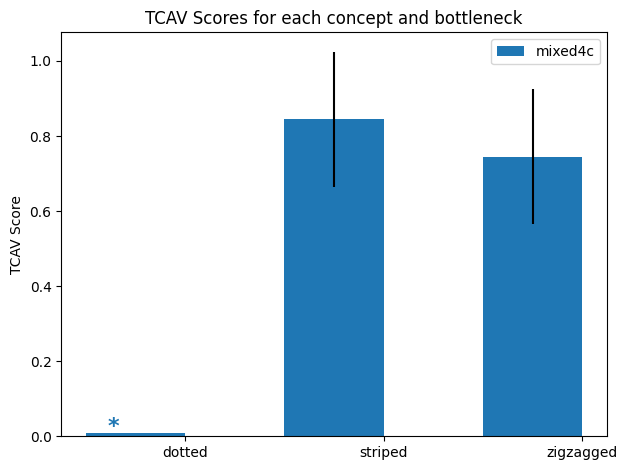

In [ ]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

## Instructions for creating your own custom model wrappers and activations class

In the original paper, there are two model wrappers included: InceptionV3 and Googlenet. You can view `model.GoogleNetWrapper_public ` to see an example of the Googlenet model wrapper.

You should define a subclass of ModelWrapper abstract class. **Below are descriptions of each function, explained by the original authors and edited for clarity for the XAI course.**

### 1. Tensors from the graph: bottleneck tensors and ends
* Store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. Only include bottlenecks that you are interested in running TCAV with.
* Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2. Define loss
Assign your loss tensor to `self.loss`. This is what TCAV uses to take directional derivatives.

Set a tensorflow placeholder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat):

```python
self.y_input
```
Here is an example of multi-class classification:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

The original authors provide the following code for a multiclass classifier:

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 3. Call _make_gradient_tensors in __init__() of your wrapper

Given the loss and bottleneck tensors defined above, this function adds gradient tensors:

```python
_make_gradient_tensors()  
```


### 4. Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format:

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

* Set your input image shape at  `self.image_shape`
* Set your model name to `self.model_name`

### 5. Implement a class that returns activations

* Implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. You can cache your activations and/or parallelize your computations (examples: `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`).

* The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. Example:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```